필요한 설치
```python
pip install pillow
pip install tensorflow_datasets # 텐서플로우에서 제공하는 데이터셋 (https://www.tensorflow.org/datasets/catalog/overview)
```

In [3]:
import tensorflow as tf
import tensorflow_datasets as tfds 
tfds.__version__

'3.2.1'

## 데이터 준비

### 데이터 로드

In [4]:
# 고양이와 강아지의 이미지 모음
(raw_train, raw_validation, raw_test), metadata = tfds.load('cats_vs_dogs',
                                                            split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
                                                            with_info=True,
                                                            as_supervised=True,)

In [5]:
print(raw_train)
print(raw_validation)
print(raw_test)

print(metadata)

<PrefetchDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>
<PrefetchDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>
<PrefetchDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>
tfds.core.DatasetInfo(
    name='cats_vs_dogs',
    version=4.0.0,
    description='A large set of images of cats and dogs.There are 1738 corrupted images that are dropped.',
    homepage='https://www.microsoft.com/en-us/download/details.aspx?id=54765',
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'image/filename': Text(shape=(), dtype=tf.string),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
    }),
    total_num_examples=23262,
    splits={
        'train': 23262,
    },
    supervised_keys=('image', 'label'),
    citation="""@Inproceedings (Conference){asirra-a-captcha-that-exploits-interest-aligned-manual-image-categorization,
    author = {Elson, Jeremy and Douceur, John (JD) a

모든 데이터셋은 (image,label)의 형태를 가집니다. ((None,None,3),())
(None, None, 3)은 image 의 shape를
()는 정답 카테고리인 label의 shape를 의미합니다.

이미지는 (height, weight, channel)로 3차원 데이터입니다.
현재 데이터셋의 모든 이미지의 크기가 전부 다르기 때문에 height와 weight가 None으로 나타난 것입니다.

label은 이미지가 고양이/강아지인지를 나타내는 단일값입니다. 1차원 숫자 하나로 표현될 수 있기 때문에 차원이 따로 나타나지 않습니다.

### 데이터 시각화

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline 
%config InlineBackend.figure_format = 'retina' 
# notebook에서 바로 확인하겠다
# 그래프를 높은 해상도로 출력한다

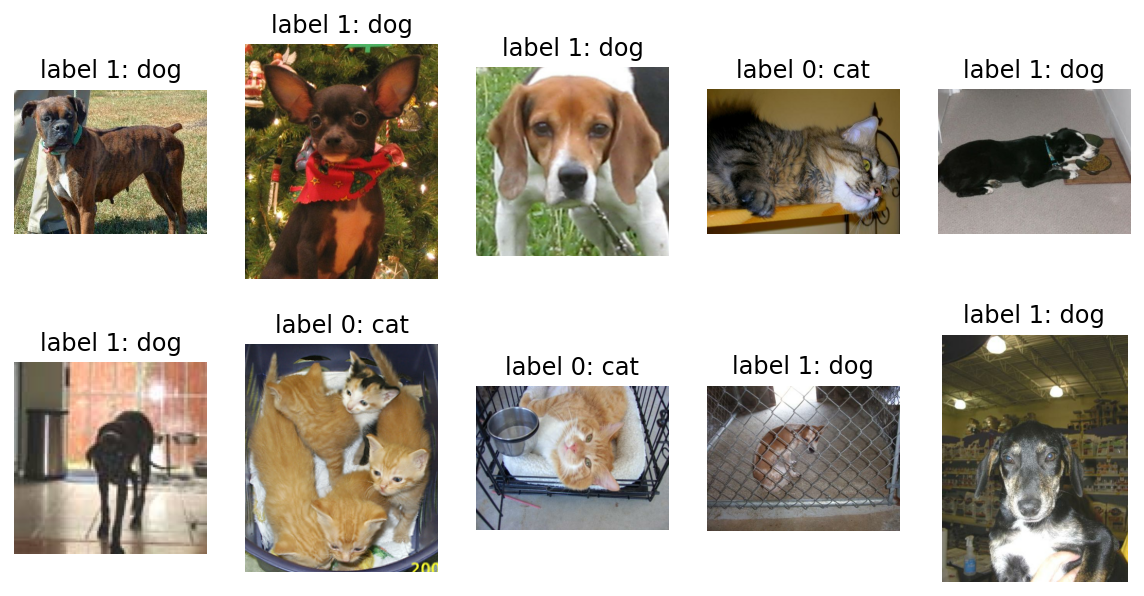

In [7]:
plt.figure(figsize=(10, 5))

get_label_name = metadata.features['label'].int2str
for idx, (image, label) in enumerate(raw_train.take(10)):
    plt.subplot(2, 5, idx+1)
    plt.imshow(image)
    plt.title(f'label {label}: {get_label_name(label)}')
    plt.axis('off')

### 데이터 사이즈 통일
모델을 학습시킬 때에는 이미지 사이즈를 통일시켜주는 작업을 해야 한다

In [8]:
IMG_SIZE = 160 # All images will be resized to 160x160

def format_example(image, label):
    image = tf.cast(image, tf.float32)  # image=float(image)같은 타입캐스팅의 텐서플로우 버전입니다.
    image = (image/127.5) - 1 # 0~255 -> -1~1
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    return image, label


In [9]:
train = raw_train.map(format_example)
validation = raw_validation.map(format_example)
test = raw_test.map(format_example)

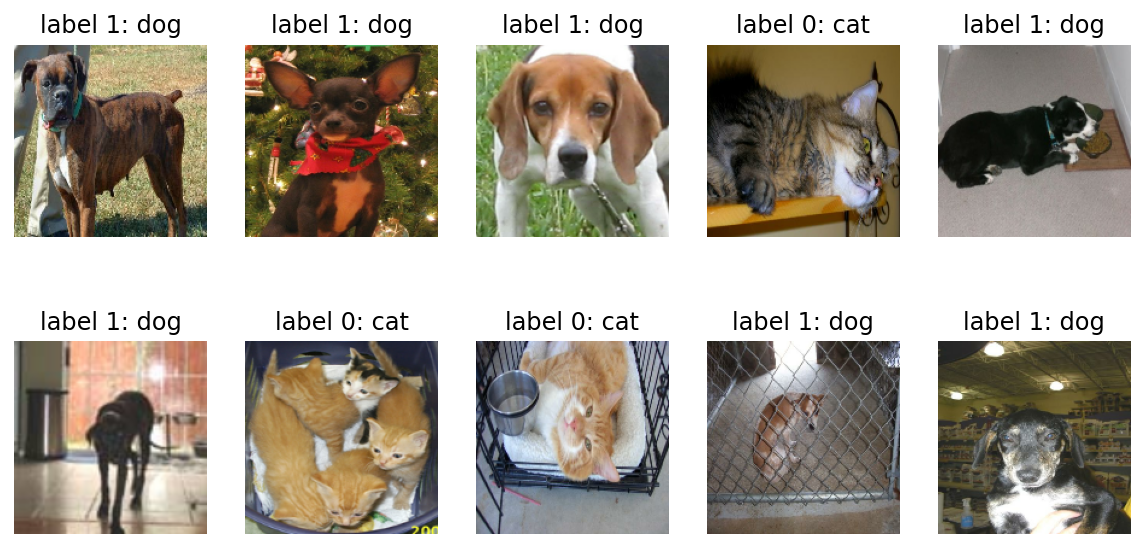

In [10]:
plt.figure(figsize=(10, 5))

get_label_name = metadata.features['label'].int2str

for idx, (image, label) in enumerate(train.take(10)):
    plt.subplot(2, 5, idx+1)
    image = (image + 1) / 2 # -1~1 인 값을 양수로 바꿔줌. 값이 0~1 로 바뀜
    plt.imshow(image)
    plt.title(f'label {label}: {get_label_name(label)}')
    plt.axis('off')

## 모델 만들기

In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D

In [12]:
model = Sequential([
    Conv2D(filters=16, 
           kernel_size=3, 
           padding='same', 
           activation='relu', 
           input_shape=(160, 160, 3)),
    MaxPooling2D(),
    Conv2D(filters=32, 
           kernel_size=3, 
           padding='same', 
           activation='relu'),
    MaxPooling2D(),
    Conv2D(filters=64, 
           kernel_size=3, 
           padding='same', 
           activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(units=512, 
          activation='relu'),
    Dense(units=2, 
          activation='softmax')
])

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 160, 160, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 80, 80, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 80, 80, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 40, 40, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 40, 40, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 20, 20, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 25600)             0

shape
- (None, height, width, channel) 4차원의 shape
- 첫 번째 차원 = 데이터의 개수, 아직 정해지지 않음, 배치 (batch) 사이즈에 따라 다른 수의 입력이 들어올 수 있음
- 네 번째 차원 = 채널, 입력 데이터가 여러 채널을 갖을 경우 필터는 각 채널을 순회하며 합성곱을 계산한 후, 채널별 피처 맵을 만듭니다. 그리고 각 채널의 피처 맵을 합산하여 최종 피처 맵으로 반환합니다. 입력 데이터는 채널 수와 상관없이 필터 별로 1개의 피처 맵이 만들어집니다. 따라서, output channel 수는 피처맵의 숫자 (= filter) 와 같습니다.


params #
 
- kernel-size = 필터 사이즈
- (3, 3) 필터 한개에는 3 x 3 = 9개의 파라미터가 있습니다.
- 그리고 입력되는 3-channel 각각에 서로 다른 파라미터들이 입력 되므로 R, G, B 에 해당하는 3이 곱해집니다.
- 그리고 Conv2D(16, ...) 에서의 16는 16개의 필터를 적용하여 다음 층에서는 채널이 총 16개가 되도록 만든다는 뜻입니다.
- 여기에 bias로 더해질 상수가 각각의 채널 마다 존재하므로 16개가 추가로 더해지게 됩니다.
- 정리하면, 3 x 3(필터 크기) x 3 (#입력 채널(RGB)) x 32(#출력 채널) + 32(출력 채널 bias) = 448이 됩니다.  [출처](https://gaussian37.github.io/dl-keras-number-of-cnn-param/)

In [14]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate),
              loss=tf.keras.losses.sparse_categorical_crossentropy,
              metrics=['accuracy'])

In [15]:
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 1000

shuffle
- shuffle_buffer_size = 1000의 의미 : 데이터셋에서 처음의 1000개를 가져온 다음에, 가져온 1000개 중에 batch를 랜덤하게 pick 
- batch_size = 32 이면, 1000개가 있는 buffer 에서 32개를 랜덤하게 뽑아서 사용. 버퍼 안에서 뽑혀나간 32개의 원소에 대해 1001~1032번째 데이터가 그 자리를 메꿈
- Buffer size가 데이터셋의 size보다 크거나 같아야 완전한 셔플이 된다고 할 수 있다.
- [출처](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#shuffle)

In [16]:
train_batches = train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
validation_batches = validation.batch(BATCH_SIZE) 
test_batches = test.batch(BATCH_SIZE)
# 데이터셋 크기를 batch_size로 나눈 만큼 batch가 만들어진다. 그만큼만 training, test 가능

In [17]:
for image_batch, label_batch in train_batches.take(1):
    pass

image_batch.shape, label_batch.shape

(TensorShape([32, 160, 160, 3]), TensorShape([32]))

In [18]:
# 모델 초기 성능 확인

validation_steps = 20 # 몇 개의 batch(batch size =32) 로 test할 것인지
loss0, accuracy0 = model.evaluate(validation_batches, steps=validation_steps)

print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

20/20 [==============================] - 1s 28ms/step - loss: 0.6948 - accuracy: 0.5031
initial loss: 0.69
initial accuracy: 0.50


## 모델 학습하기

In [20]:
EPOCHS = 10
history = model.fit(train_batches,
                    epochs=EPOCHS,
                    validation_data=validation_batches)

Epoch 1/10
582/582 [==============================] - 24s 41ms/step - loss: 0.3770 - accuracy: 0.8330 - val_loss: 0.4752 - val_accuracy: 0.7782
Epoch 2/10
582/582 [==============================] - 24s 41ms/step - loss: 0.3191 - accuracy: 0.8639 - val_loss: 0.5491 - val_accuracy: 0.7558
Epoch 3/10
582/582 [==============================] - 24s 42ms/step - loss: 0.2666 - accuracy: 0.8912 - val_loss: 0.6047 - val_accuracy: 0.7425
Epoch 4/10
582/582 [==============================] - 23s 40ms/step - loss: 0.2125 - accuracy: 0.9159 - val_loss: 0.5121 - val_accuracy: 0.7863
Epoch 5/10
582/582 [==============================] - 25s 43ms/step - loss: 0.1702 - accuracy: 0.9383 - val_loss: 0.5428 - val_accuracy: 0.7958
Epoch 6/10
582/582 [==============================] - 24s 42ms/step - loss: 0.1248 - accuracy: 0.9566 - val_loss: 0.6088 - val_accuracy: 0.7898
Epoch 7/10
582/582 [==============================] - 25s 42ms/step - loss: 0.0882 - accuracy: 0.9722 - val_loss: 0.6778 - val_accuracy:

## 모델 성능 평가하기

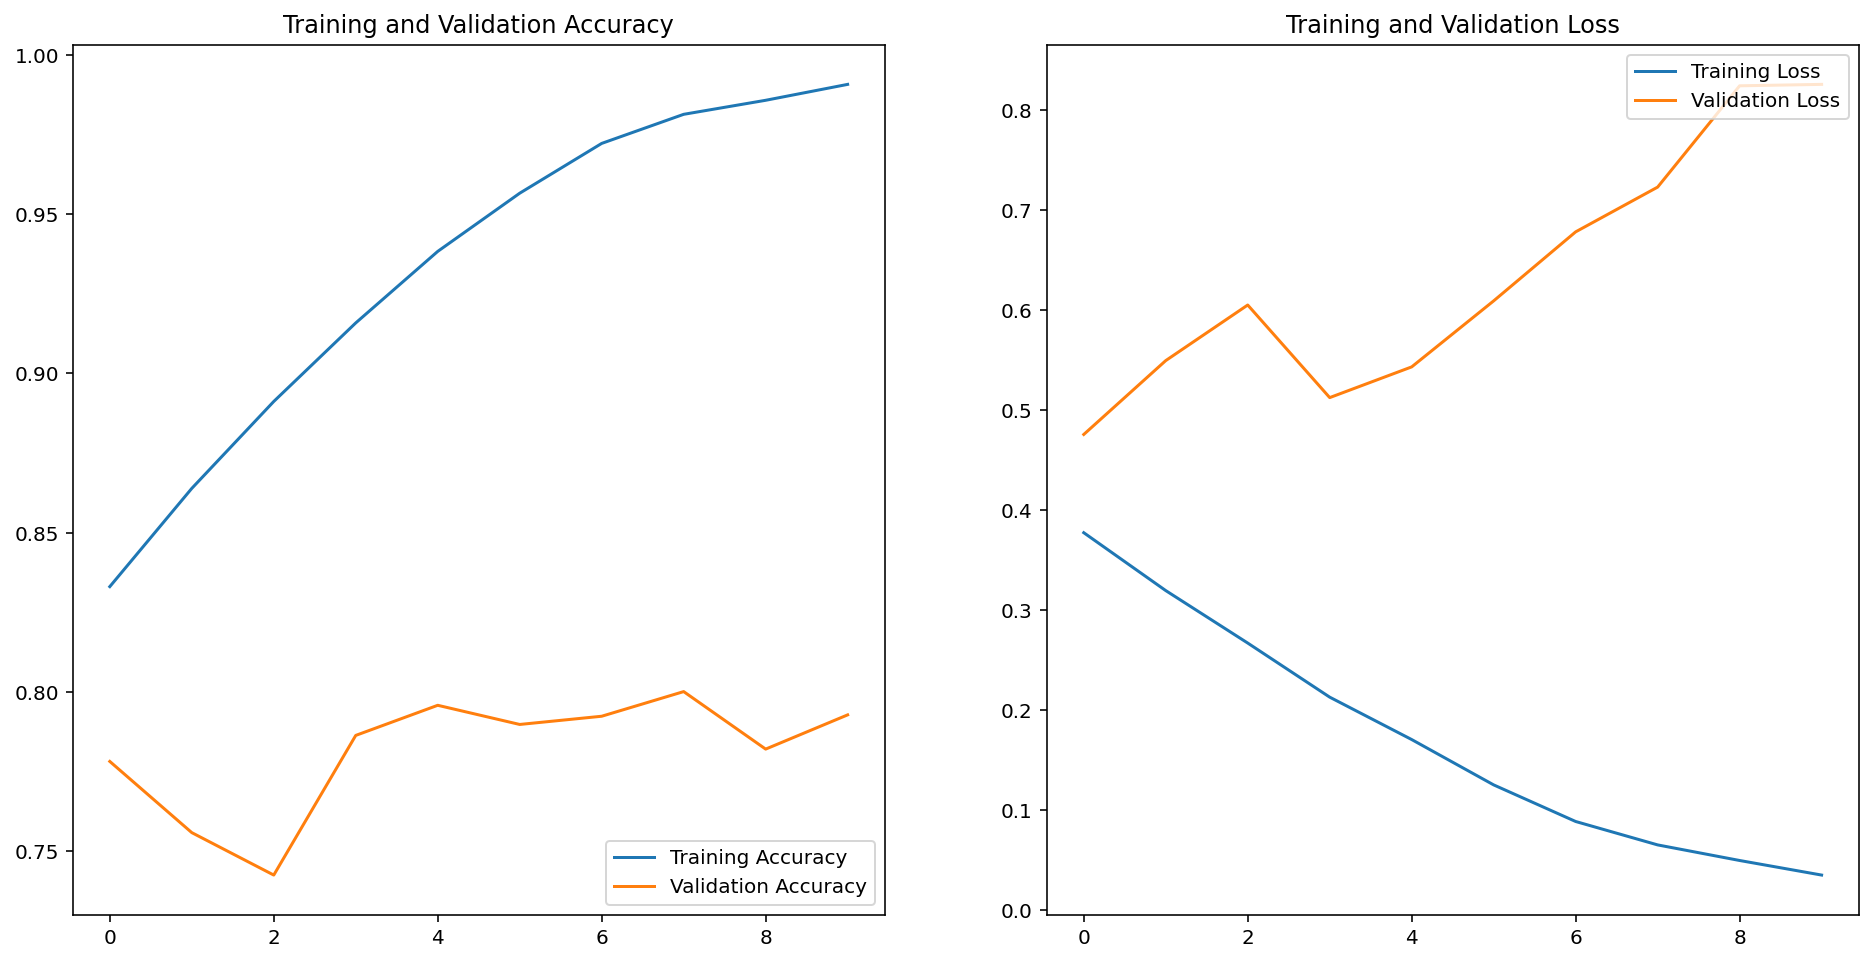

In [21]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


### 하나 꺼내서 확인해보기

In [22]:
for image_batch, label_batch in test_batches.take(1):
    images = image_batch
    labels = label_batch
    predictions = model.predict(images)
    pass

predictions

array([[9.99999881e-01, 1.48362645e-07],
       [8.21533978e-01, 1.78465977e-01],
       [1.37971565e-02, 9.86202836e-01],
       [1.00000000e+00, 2.98771496e-08],
       [9.54656005e-01, 4.53439727e-02],
       [7.02370424e-03, 9.92976308e-01],
       [2.29358170e-06, 9.99997735e-01],
       [2.23943099e-01, 7.76056945e-01],
       [1.33304838e-02, 9.86669540e-01],
       [2.10931525e-01, 7.89068460e-01],
       [4.41974625e-02, 9.55802560e-01],
       [9.22066391e-01, 7.79335350e-02],
       [9.94981706e-01, 5.01835905e-03],
       [2.37311833e-05, 9.99976277e-01],
       [9.99790490e-01, 2.09479025e-04],
       [9.99999642e-01, 4.10492106e-07],
       [7.08587170e-01, 2.91412830e-01],
       [1.76129856e-06, 9.99998212e-01],
       [7.06123114e-01, 2.93876857e-01],
       [7.20005155e-01, 2.79994816e-01],
       [9.97818708e-01, 2.18123570e-03],
       [4.95080560e-01, 5.04919469e-01],
       [9.99999285e-01, 7.01758495e-07],
       [9.97038722e-01, 2.96132476e-03],
       [9.999934

In [23]:
import numpy as np
predictions = np.argmax(predictions, axis=1)
predictions

array([0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1,
       0, 0, 0, 1, 0, 1, 0, 0, 0, 1])

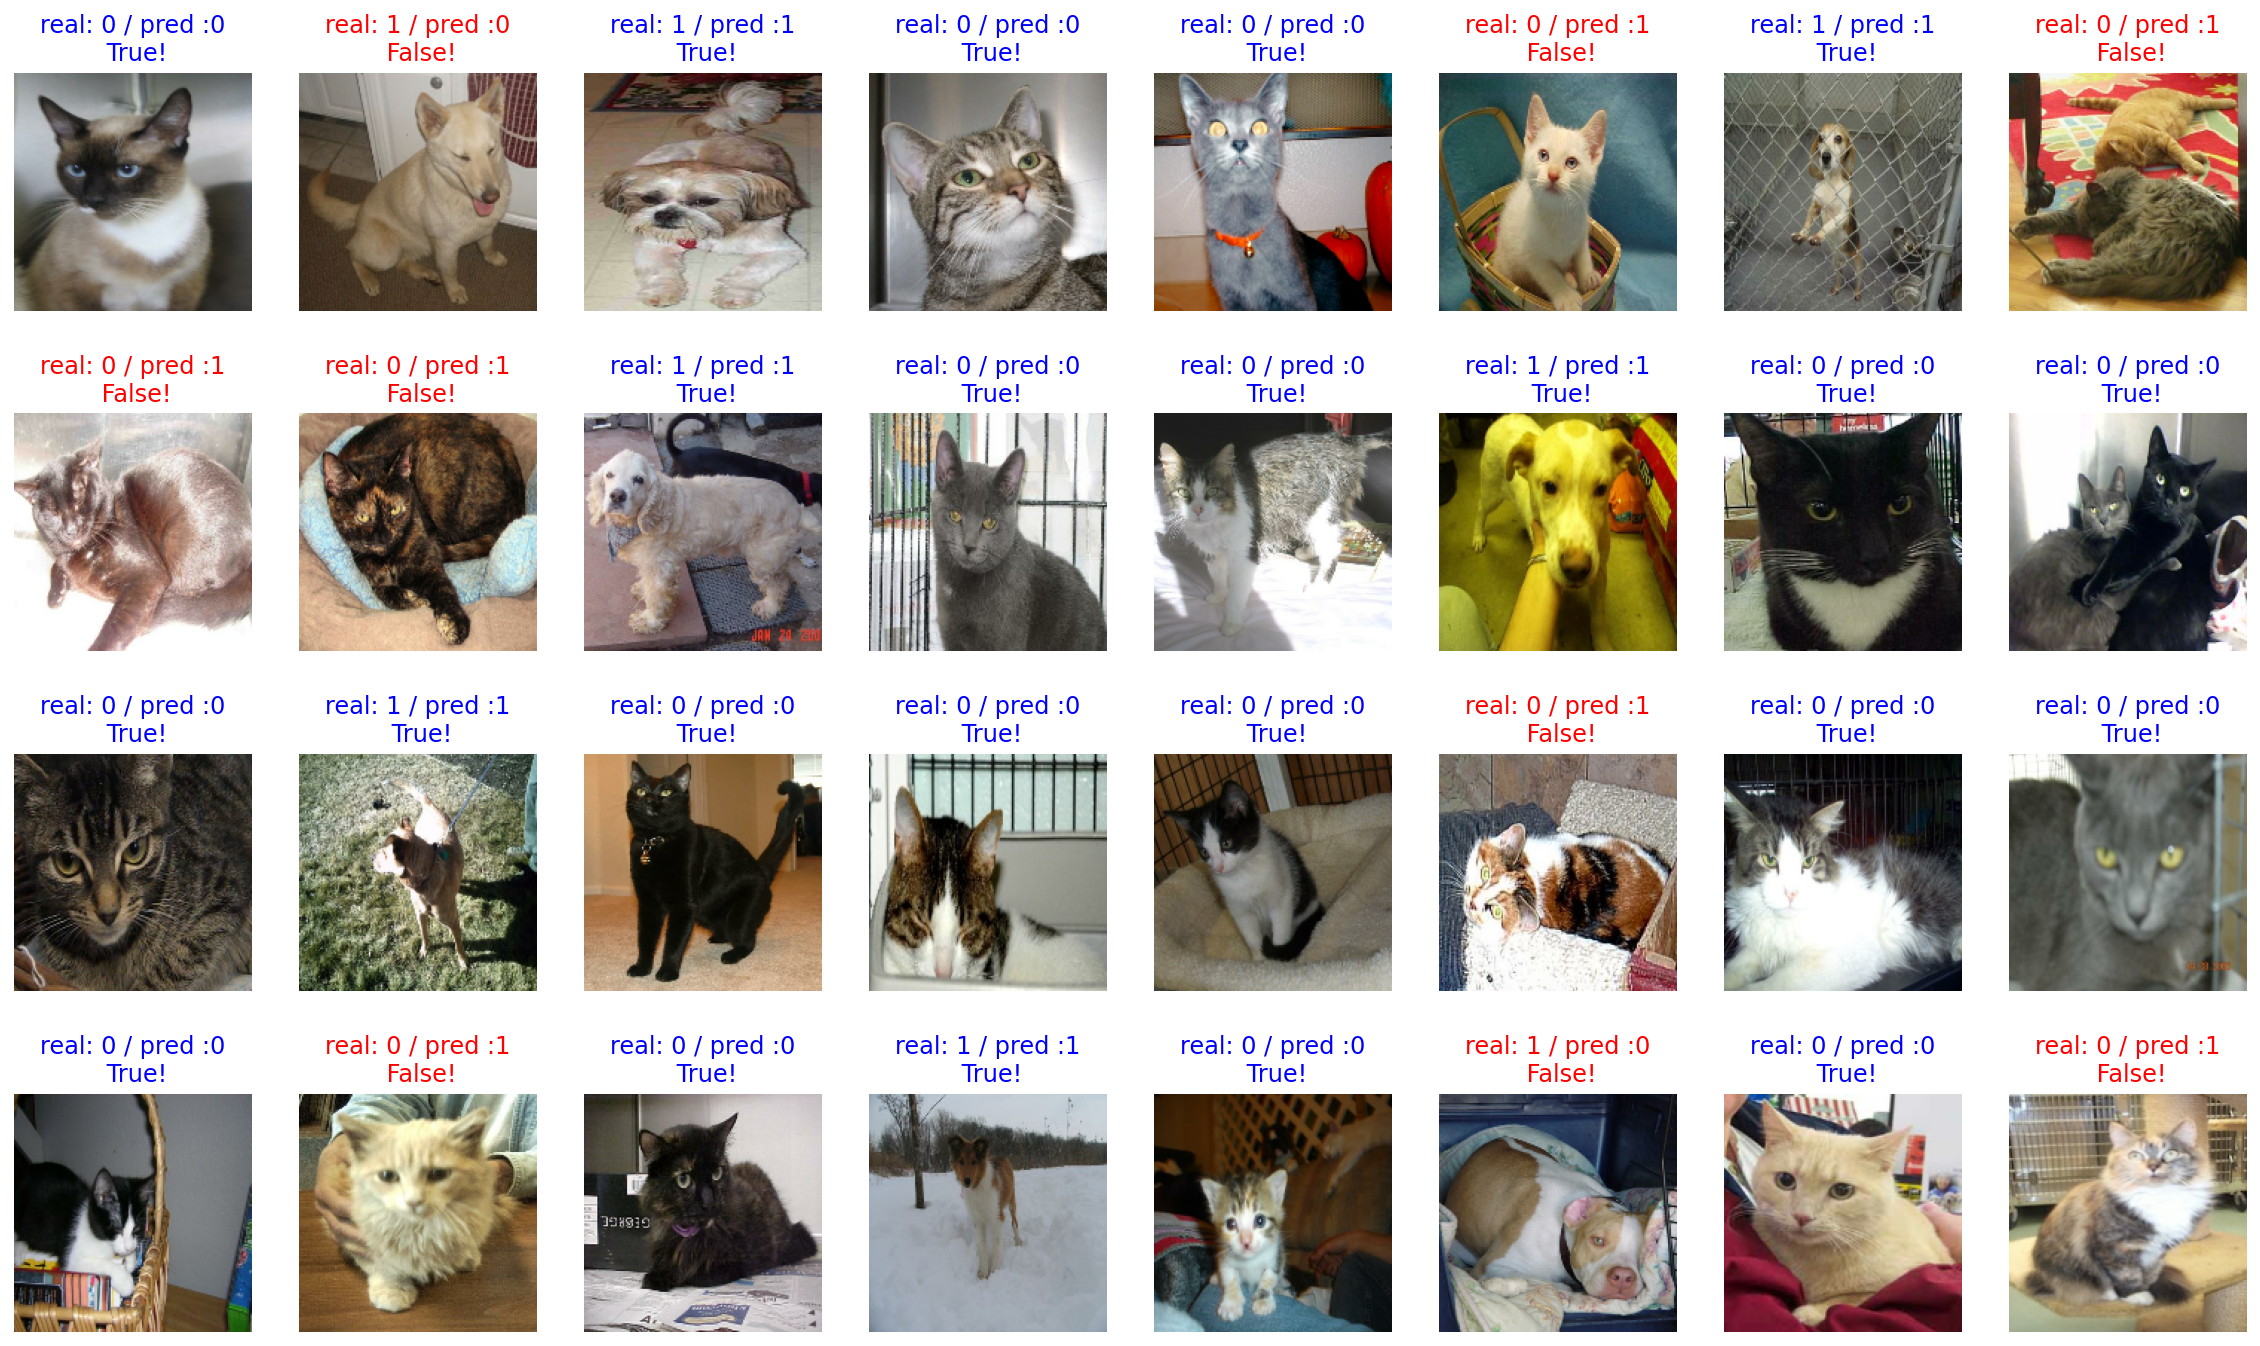

In [24]:
plt.figure(figsize=(20, 12))

for idx, (image, label, prediction) in enumerate(zip(images, labels, predictions)):
    plt.subplot(4, 8, idx+1)
    image = (image + 1) / 2
    plt.imshow(image)
    correct = label == prediction
    title = f'real: {label} / pred :{prediction}\n {correct}!'
    if not correct:
        plt.title(title, fontdict={'color': 'red'})
    else:
        plt.title(title, fontdict={'color': 'blue'})
    plt.axis('off')

이미 많은 데이터로 학습된 모델을 이용하는 방법 (Transfer Learning) [Go](https://github.com/nr-ai/Aiffel_Exploration/blob/master/AnimalFaceClassifier_TranserLearning.ipynb)